### 1. Import Module

In [18]:
import numpy as np
import matplotlib.pyplot as plt 

import torch 
import torchvision 
import torchvision.transforms as transforms 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

import time
t1 = time.perf_counter()

### 2. Load and normalize data

In [19]:
# Hyper-parameters
num_epochs = 4 
batch_size = 4 
num_workers = 2
learning_rate = 0.001
weight_decay = 5e-4
momentum = 0.9

Files already downloaded and verified
Files already downloaded and verified


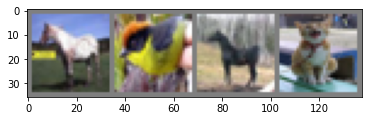

horse bird horse cat


In [20]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset has images of range [0, 1]
# We transform them to Tensors of normalized range [-1, 1]

transform = transforms.Compose( #composing several transforms together
    [transforms.ToTensor(), #to tensor object
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]) # mean=0.5, std=0.5

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
# Load train data
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers = num_workers)
# Load test data
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers = num_workers)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Visualize images
def imshow(img):
    img = img / 2 + 0.5 # Unnormalize
    npimg = img.numpy() # Convert to numpy 
    plt.imshow(np.transpose(npimg, (1,2,0))) 
    plt.show()

# Get random training images with iter function
dataiter = iter(train_loader)
images, labels = dataiter.next()

# Call function on out images
imshow(torchvision.utils.make_grid(images))

# Print the class of the image
print(' '.join('%s' % classes[labels[j]] for j in range(batch_size)))

### 3. Define the CNN 

In [21]:
# LeNet-5 by Yann LeCun
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2)  
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x

network = LeNet().to(device)

### 4. Define a Loss function and optimzer

In [22]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD([{'params': network.parameters()}], lr=learning_rate, weight_decay=weight_decay, momentum=momentum) 

### 5. Train the network

In [23]:
loss_hist, acc_hist = [], []
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = network(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad() # Zero the parameter gradients
        loss.backward() # Backpropagation
        optimizer.step() # Iterates over all the parameters and update their values

        # Compute training statistics
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            
    avg_loss = running_loss / len(train_dataset)
    avg_acc = correct / len(train_dataset)
    loss_hist.append(avg_loss)
    acc_hist.append(avg_acc)

Epoch [1/4], Step [2000/12500], Loss: 2.4504
Epoch [1/4], Step [4000/12500], Loss: 1.4564
Epoch [1/4], Step [6000/12500], Loss: 0.9343
Epoch [1/4], Step [8000/12500], Loss: 1.2517
Epoch [1/4], Step [10000/12500], Loss: 1.3590
Epoch [1/4], Step [12000/12500], Loss: 1.0212
Epoch [2/4], Step [2000/12500], Loss: 1.2052
Epoch [2/4], Step [4000/12500], Loss: 0.7449
Epoch [2/4], Step [6000/12500], Loss: 0.5702
Epoch [2/4], Step [8000/12500], Loss: 1.0505
Epoch [2/4], Step [10000/12500], Loss: 0.6065
Epoch [2/4], Step [12000/12500], Loss: 2.9192
Epoch [3/4], Step [2000/12500], Loss: 1.5966
Epoch [3/4], Step [4000/12500], Loss: 0.5140
Epoch [3/4], Step [6000/12500], Loss: 0.9339
Epoch [3/4], Step [8000/12500], Loss: 0.9081
Epoch [3/4], Step [10000/12500], Loss: 0.7373
Epoch [3/4], Step [12000/12500], Loss: 1.4046
Epoch [4/4], Step [2000/12500], Loss: 1.0016
Epoch [4/4], Step [4000/12500], Loss: 0.3808
Epoch [4/4], Step [6000/12500], Loss: 0.6458
Epoch [4/4], Step [8000/12500], Loss: 1.1495
Epoc

In [24]:
# Save neural network
print('Finished Training')
PATH = './cnn.pth'
torch.save(network.state_dict(), PATH)

Finished Training


### 6. Test the network on test data

In [25]:
# Load neural network
network = LeNet().to(device)
network.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [26]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device) 
        outputs = network(images)
        _, predicted = torch.max(outputs, 1) 
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 60.74 %
Accuracy of airplane: 65.3 %
Accuracy of automobile: 80.4 %
Accuracy of bird: 45.4 %
Accuracy of cat: 37.6 %
Accuracy of deer: 45.4 %
Accuracy of dog: 53.5 %
Accuracy of frog: 68.5 %
Accuracy of horse: 76.3 %
Accuracy of ship: 72.4 %
Accuracy of truck: 62.6 %


### 5. Plot Training Statistics

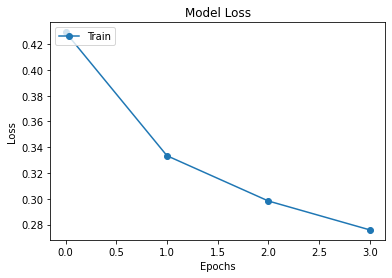

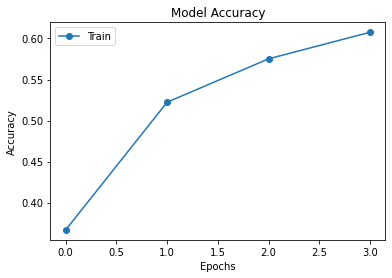

time taken to run: 242.27284345199996


In [27]:
import matplotlib.pyplot as plt

legend = ['Train']
plt.plot(loss_hist,'o-')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')
plt.show()

legend = ['Train']
plt.plot(acc_hist,'o-')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

t2 = time.perf_counter()
print('Time taken to run:',t2-t1)